In [1]:
import numpy as np
import pandas as pd
from skimage import img_as_float
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
from tqdm import tqdm
%matplotlib inline

In [2]:
data = scipy.io.loadmat("facedata.mat")
# There are 40 people in the database & each person has 10 images.
# image dimension is .. 
print(data["facedata"][0,0].shape)

(56, 46)


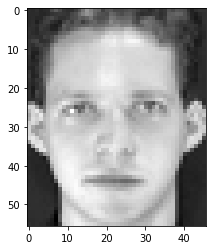

In [3]:
plt.imshow(data["facedata"][0,0], cmap='gray')
plt.show()

In [4]:
# Convert [0,255] to floats or doubles
# Scales down 0-255 to 0-1
xf = {}
xf[0,0] = img_as_float(data['facedata'][0,0])
print(xf[0,0])

[[0.18823529 0.18039216 0.19607843 ... 0.19607843 0.21176471 0.20784314]
 [0.18431373 0.18431373 0.18823529 ... 0.14509804 0.18039216 0.19607843]
 [0.18039216 0.18823529 0.16862745 ... 0.12941176 0.16078431 0.2       ]
 ...
 [0.19215686 0.19215686 0.19607843 ... 0.17647059 0.18039216 0.18431373]
 [0.18823529 0.18823529 0.19215686 ... 0.17647059 0.18039216 0.18039216]
 [0.2        0.18823529 0.19607843 ... 0.17647059 0.17647059 0.18039216]]


# Simple Verification

In [5]:
def scale_to_float(img):
    return img_as_float(img)

def get_EuclidDist(img1, img2):
    x1 = scale_to_float(img1).reshape(1, img1.shape[0]*img1.shape[1])
    x2 = scale_to_float(img2).reshape(1, img2.shape[0]*img2.shape[1])
    dist = np.sqrt(np.sum(np.square(x2-x1), axis=1))
    return dist

# T6
def get_Similarity(data_T, data_D):
    sim = []
    imgT = np.array([scale_to_float(img) for person in data_T for img in person])
    imgT = imgT.reshape(len(imgT), imgT[0].shape[0]*imgT[0].shape[1])
    imgD = np.array([scale_to_float(img) for person in data_D for img in person])
    imgD = imgD.reshape(len(imgD), imgD[0].shape[0]*imgD[0].shape[1])
    for i in range(len(imgT)):
        dist = np.sqrt(np.sum(np.square(imgT[i]-imgD), axis=1))
        sim.append(dist)
    return np.array(sim)

def split_data(data_list):
    T_list = data["facedata"][:, :3]
    D_list = data["facedata"][:, 3:10]
    return T_list, D_list

In [6]:
# T5
print(get_EuclidDist(data['facedata'][0,0], data['facedata'][0,1]))
print(get_EuclidDist(data['facedata'][0,0], data['facedata'][1,0]))

[10.03761629]
[8.1732951]


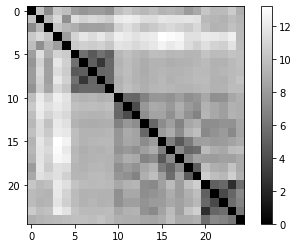

In [7]:
# T6
T_data, D_data = split_data(data)
sim = get_Similarity(data_T = data['facedata'][:5, :5], data_D = data['facedata'][:5, :5])
plt.imshow(sim, cmap="gray")
plt.colorbar()
plt.show()

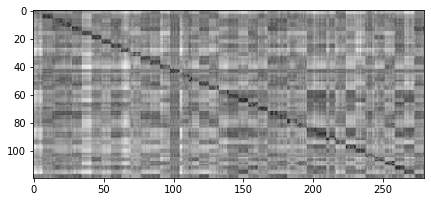

In [8]:
T_data, D_data = split_data(data)
sim = get_Similarity(T_data, D_data)
plt.figure(figsize=(7,7))
plt.imshow(sim, cmap="gray")
plt.show()

In [9]:
# T8
def Face_verification(sim, t):
    min_sim = []
    tp_all = 0
    tn_all = 0
    fp_all = 0
    fn_all = 0
    for i in range(0, sim.shape[0], 3):
        min_sim.append(np.min(sim[i:i+3, :], axis=0))
    
    min_sim = np.array(min_sim)
    pred = (min_sim < t)
    for idx, j in enumerate(range(0, min_sim.shape[1], 7)):
        tp = np.sum(pred[:, j:j+7][idx])
        fn = 7-tp
        fp = np.sum(pred[:, j:j+7]) - tp
        tn = pred.shape[1] - fp - fn - tp
        tp_all += tp
        tn_all += tn
        fp_all += fp
        fn_all += fn
    return {"True positive": tp_all,
               "True negative": tn_all,
               "False positive": fp_all,
               "False negative": fn_all}, tp_all/(tp_all+fn_all), fp_all/(fp_all+tn_all)

In [10]:
conf, tp_rate, false_alarm = Face_verification(sim, 10)

In [11]:
print(conf)
print(tp_rate)
print(false_alarm)

{'True positive': 279, 'True negative': 5936, 'False positive': 4984, 'False negative': 1}
0.9964285714285714
0.4564102564102564


In [12]:
# T9 & T10
def plot_roc(sim, size, plot=True):
    if plot == True:
        plt.figure(figsize=(7,7))
    tmin = np.floor(np.min(sim))
    tmax = np.ceil(np.max(sim))
    step = (tmax-tmin)/size
    tpr_list = []
    fpr_list = []
    t_list = np.arange(tmin, tmax, step)
    recall_index = []
    for idx, t in enumerate(t_list):
        conf, tpr, fpr = Face_verification(sim, t)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        if fpr >= 0.1:
            recall_index.append(idx)
        if idx%100 == 0 and plot==True:
            plt.scatter(fpr, tpr, marker="o", color='red',  s=100, edgecolors='black')
            plt.annotate(f"t = {np.round(t)}", (fpr, tpr+0.015))
    
    if plot==True:
        plt.plot(fpr_list, tpr_list, lw=3, label="Face verification")
        plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Alarm Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic")
        plt.legend(loc="lower right")
        plt.show()
    
    fnr_list = 1-np.array(tpr_list)
    fpr_list = np.array(fpr_list)    
    abs_diffs = np.abs(fpr_list - fnr_list)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((fpr_list[min_index],  fnr_list[min_index]))
    print("Equal error rate : " , eer)
    print("At Threshold : ", t_list[min_index])
    print("0.1% FAR Precision : ", tpr_list[recall_index[0]]/(tpr_list[recall_index[0]]+fpr_list[recall_index[0]]))
    print("0.1% FAR Recall : ", tpr_list[recall_index[0]]/(tpr_list[recall_index[0]]+fnr_list[recall_index[0]]))
    return eer

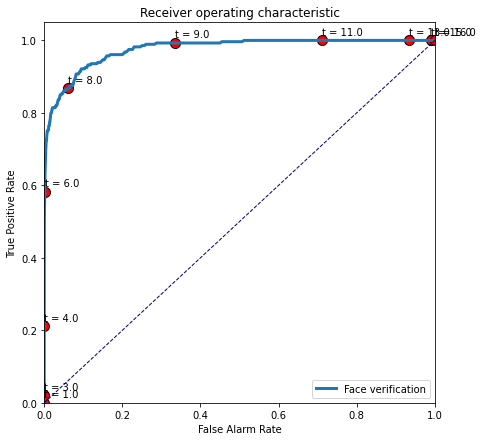

Equal error rate :  0.08946886446886448
At Threshold :  8.08899999999996
0.1% FAR Precision :  0.9013705993012631
0.1% FAR Recall :  0.9214285714285714


In [13]:
_ = plot_roc(sim, size=1000)

# Principle Component Analysis

In [14]:
T_data, D_data = split_data(data)
X_train = np.array([scale_to_float(img) for person in T_data for img in person]).reshape(120, 56*46).T
X_test = np.array([scale_to_float(img) for person in D_data for img in person]).reshape(280, 56*46).T
X_train.shape

(2576, 120)

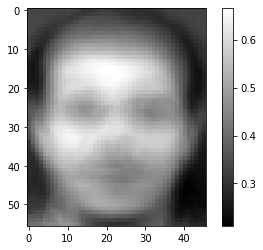

In [15]:
# T11
X_mean = np.mean(X_train, axis=1)
plt.imshow(X_mean.reshape(56, 46), cmap="gray")
plt.colorbar()
plt.show()

In [16]:
# T12 --> cov size (2576, 2576) --> rank (119)

In [17]:
# T13 --> gramm (120, 120) --> rank (119)
X_tilda = X_train-X_mean.reshape(len(X_mean),1)
cov = np.dot(X_tilda, X_tilda.T)
gramm = np.dot(X_tilda.T, X_tilda)

In [18]:
# T14 & T15
D, Q_gramm = np.linalg.eigh(gramm)
D = D[::-1] # Descending sort
Q_gramm = Q_gramm[:, np.argsort(D)] # Descending sort

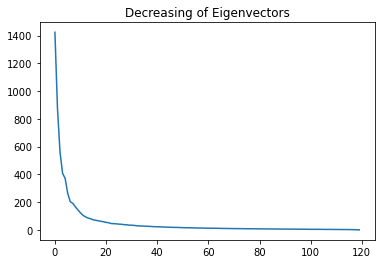

64  Eigenvectors will explaine 95% varaince of this data.


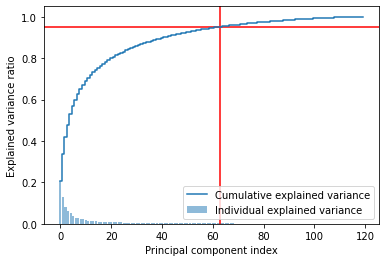

In [19]:
# T16
plt.plot(D)
plt.title("Decreasing of Eigenvectors")
plt.show()

exp_var = 0
exp_var_hist = []
exp_var_cumulative = []
found = False
for i in range(len(D)):
    exp_var += (D/(np.sum(D)))[i]
    exp_var_hist.append((D/(np.sum(D)))[i])
    exp_var_cumulative.append(exp_var)
    if exp_var > 0.95 and found == False:
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.axvline(x=i, color='r', linestyle='-')
        print(i+1, " Eigenvectors will explaine 95% varaince of this data.")
        found = True;
plt.step(range(0,len(exp_var_cumulative)), exp_var_cumulative, where='mid',label='Cumulative explained variance')
plt.bar(range(0,len(exp_var_hist)), exp_var_hist, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [20]:
Q = np.dot(X_tilda, Q_gramm)
Q = Q/np.linalg.norm(Q, axis=0)

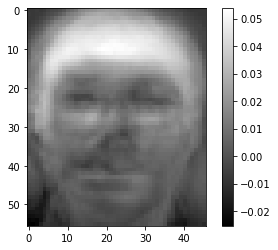

In [21]:
plt.imshow(Q[:,0].reshape(56, 46), cmap="gray")
plt.colorbar()
plt.show()

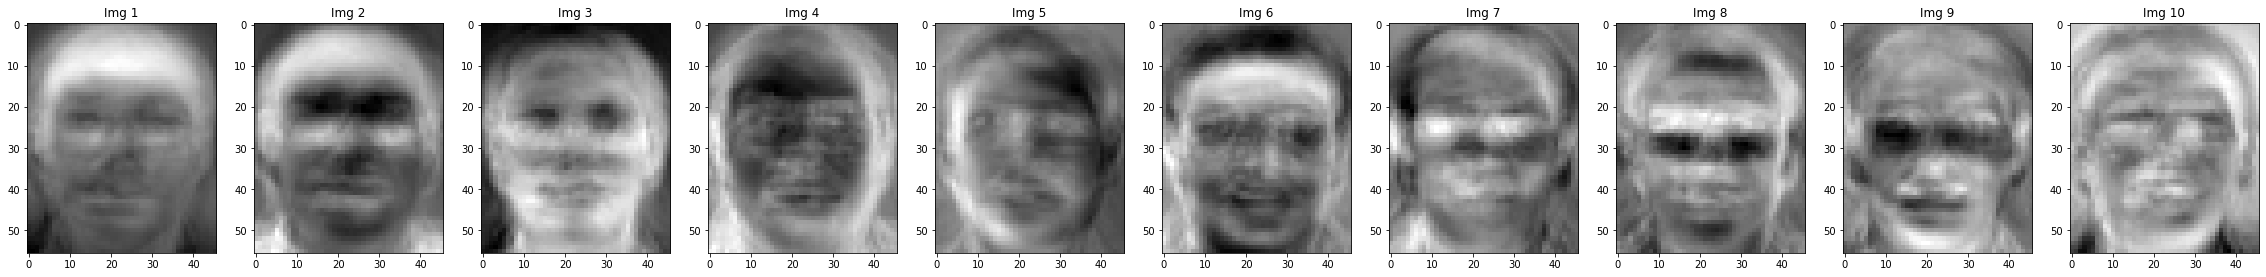

In [22]:
# T17
plt.figure(figsize=(40,20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title('Img {}'.format(i+1))
    plt.imshow(Q[:, i].reshape(56,46), cmap="gray")
plt.show()

# PCA Verification system

In [23]:
def get_pca_data(train_data, test_data, mean, dim=10):
    PCA_dim = dim # From 56*46
    X_train_tilda = train_data-mean.reshape(len(mean),1)
    X_test_tilda = test_data-mean.reshape(len(mean),1)

    X_train_pca = np.dot(Q[:, :PCA_dim].T, X_train_tilda) # New data shape (100, 120)
    X_test_pca = np.dot(Q[:, :PCA_dim].T, X_test_tilda) # New data shape (100, 280)
    return X_train_pca, X_test_pca

In [24]:
def get_Similarity_pca(train_data, test_data):
    sim = []
    for i in range(train_data.shape[1]):
        base = train_data[:, i].reshape(train_data.shape[0],1)
        dist = np.sqrt(np.sum(np.square(base-test_data), axis=0))
        sim.append(dist)
    return np.array(sim)

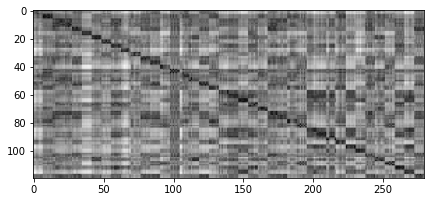

In [25]:
X_train_pca, X_test_pca = get_pca_data(dim=10, train_data=X_train, test_data=X_test, mean=X_mean)
sim_pca = get_Similarity_pca(X_train_pca, X_test_pca)
plt.figure(figsize=(7,7))
plt.imshow(sim_pca, cmap="gray")
plt.show()

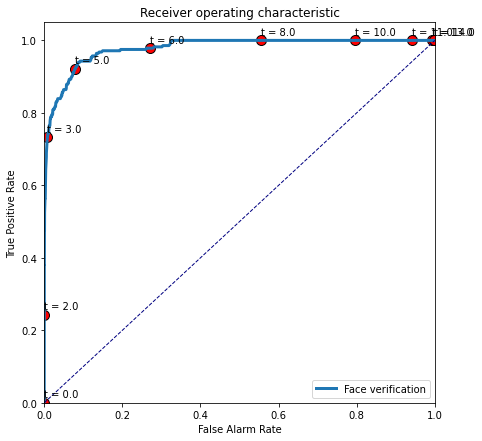

Equal error rate :  0.0784798534798535
At Threshold :  4.784
0.1% FAR Precision :  0.9026036644165862
0.1% FAR Recall :  0.9428571428571428


In [26]:
# T19
_ = plot_roc(sim_pca, size=1000)

In [27]:
# T20
eer_list = []
k_list = np.arange(5,15,1)
for k in k_list:
    print("\nK = ", k)
    X_train_pca, X_test_pca = get_pca_data(dim=k, train_data=X_train, test_data=X_test, mean=X_mean)
    sim_pca = get_Similarity_pca(X_train_pca, X_test_pca)
    eer = plot_roc(sim_pca, size=1000, plot=False)
    eer_list.append(eer)


K =  5
Equal error rate :  0.10750915750915749
At Threshold :  3.712
0.1% FAR Precision :  0.8977632805219012
0.1% FAR Recall :  0.8821428571428571

K =  6
Equal error rate :  0.09358974358974359
At Threshold :  4.0
0.1% FAR Precision :  0.9006273297572507
0.1% FAR Recall :  0.9071428571428571

K =  7
Equal error rate :  0.09271978021978022
At Threshold :  4.288
0.1% FAR Precision :  0.9004329004329005
0.1% FAR Recall :  0.9142857142857143

K =  8
Equal error rate :  0.08571428571428573
At Threshold :  4.496
0.1% FAR Precision :  0.902697409418677
0.1% FAR Recall :  0.9285714285714286

K =  9
Equal error rate :  0.08136446886446888
At Threshold :  4.64
0.1% FAR Precision :  0.9021901662415339
0.1% FAR Recall :  0.9392857142857143

K =  10
Equal error rate :  0.0784798534798535
At Threshold :  4.784
0.1% FAR Precision :  0.9026036644165862
0.1% FAR Recall :  0.9428571428571428

K =  11
Equal error rate :  0.0779761904761905
At Threshold :  4.96
0.1% FAR Precision :  0.9029539607912711


In [28]:
k_list[np.argmin(eer_list)]

11

## Data Reconstruction

In [29]:
def mse(rec_data, actual_data):
    return np.sum(np.square(rec_data-actual_data))

def Reconstruction(pca_data, img_index, Q, mean, PCA_dim=100):
    rec = np.sum(Q[:, :PCA_dim]*pca_data[:, img_index], axis=1) + mean
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
    ax1.imshow(rec.reshape(56,46), cmap="gray")
    ax1.set(title="PCA Reconstruction, Dim = {}".format(PCA_dim))
    ax2.imshow(X_train[:, img_index].reshape(56,46), cmap="gray")
    ax2.set(title="Actual image, Dim = {}".format(56*46))
    plt.show()
    print("Mean square error (MSE) : " ,mse(rec, X_train[:, img_index]))
    return [rec, X_train[:, img_index], mse(rec, X_train[:, img_index])]

In [30]:
PCA_dim = 10 # From 56*46
X_pca, _ = get_pca_data(train_data=X_train, test_data=X_test, mean=X_mean, dim=PCA_dim) # New data shape (100, 120)

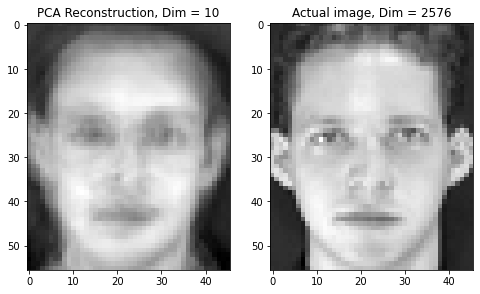

Mean square error (MSE) :  15.838111002473873


In [31]:
# OT1
_ = Reconstruction(pca_data=X_pca, img_index=0, Q=Q, mean=X_mean, PCA_dim=PCA_dim)


K :  1


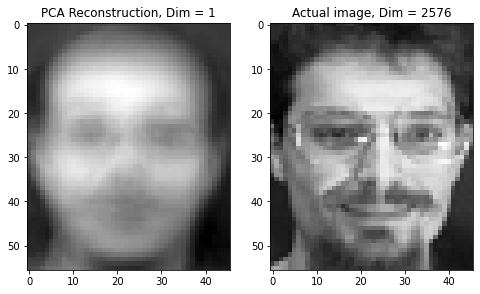

Mean square error (MSE) :  44.033006443082826

K :  2


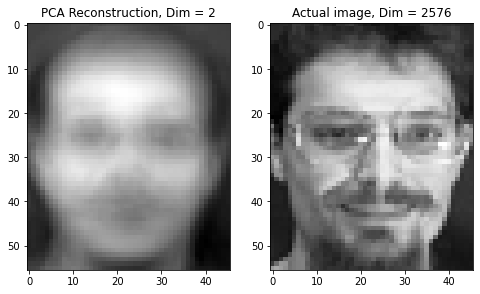

Mean square error (MSE) :  43.61766615321626

K :  3


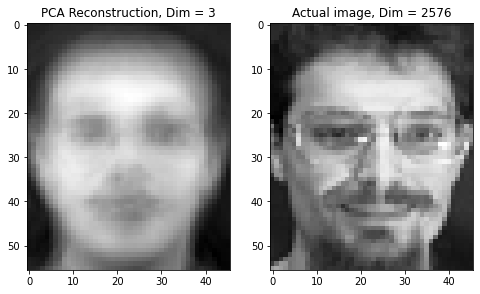

Mean square error (MSE) :  37.75522779816018

K :  4


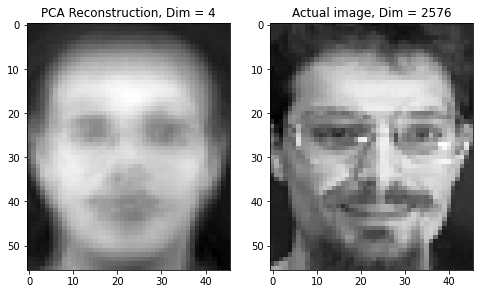

Mean square error (MSE) :  37.67973054891769

K :  5


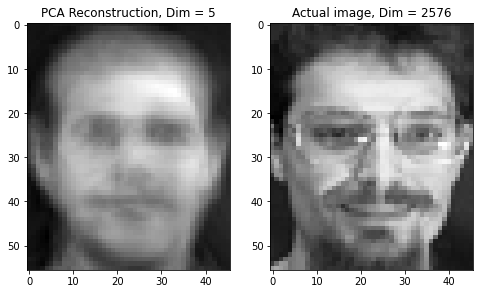

Mean square error (MSE) :  25.69708754102375

K :  6


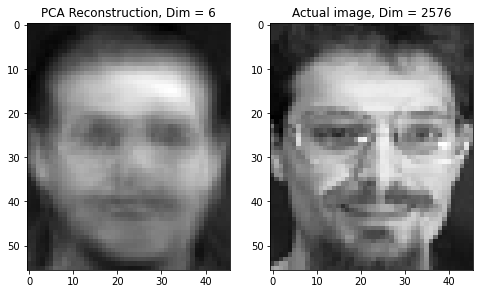

Mean square error (MSE) :  19.68458930121855

K :  7


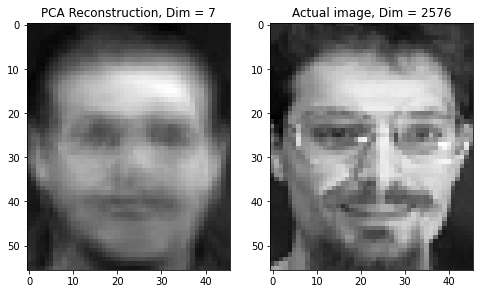

Mean square error (MSE) :  19.62696105570346

K :  8


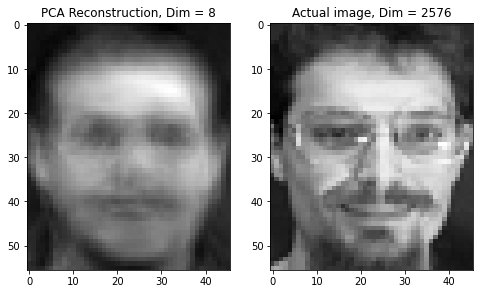

Mean square error (MSE) :  19.626959512494693

K :  9


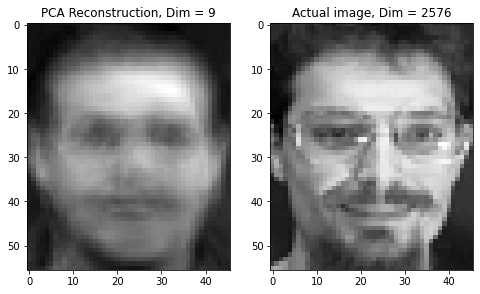

Mean square error (MSE) :  19.62113326600889

K :  10


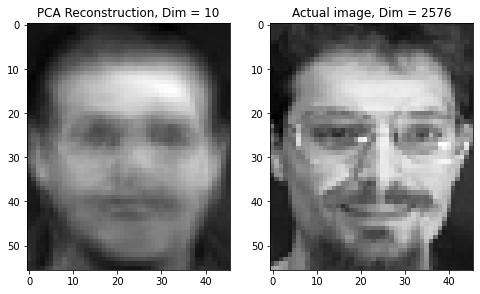

Mean square error (MSE) :  19.61863325909841

K :  11


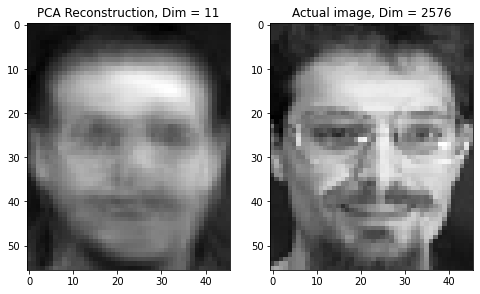

Mean square error (MSE) :  19.112404212485906

K :  12


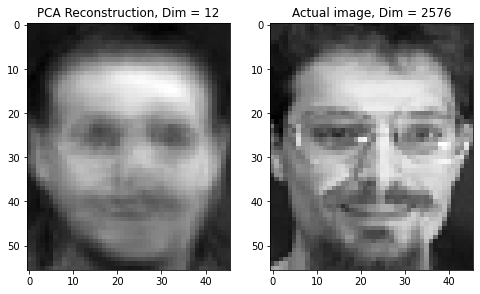

Mean square error (MSE) :  18.67775153180912

K :  13


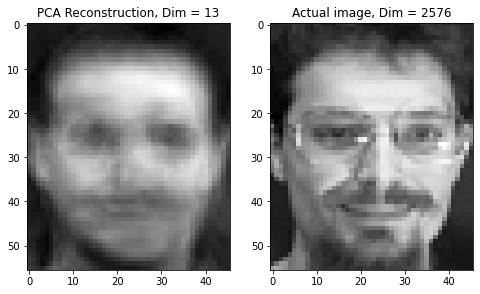

Mean square error (MSE) :  17.780170058597324

K :  14


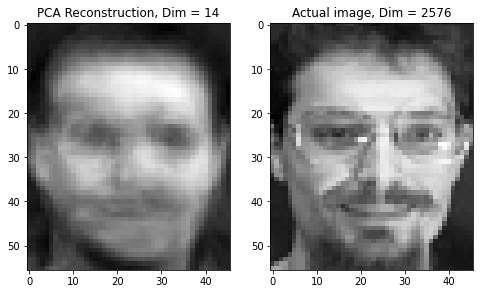

Mean square error (MSE) :  17.121729052551927

K :  15


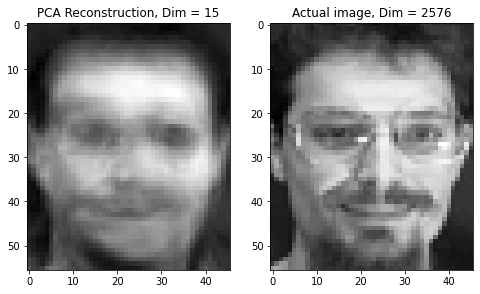

Mean square error (MSE) :  15.980302354160884

K :  16


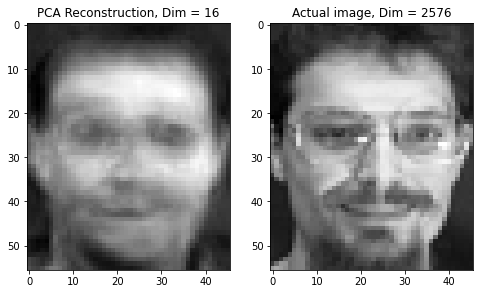

Mean square error (MSE) :  15.041970871317638

K :  17


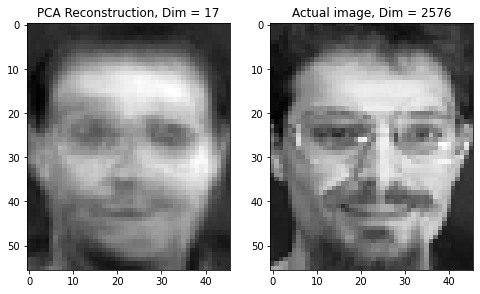

Mean square error (MSE) :  14.651872305848734

K :  18


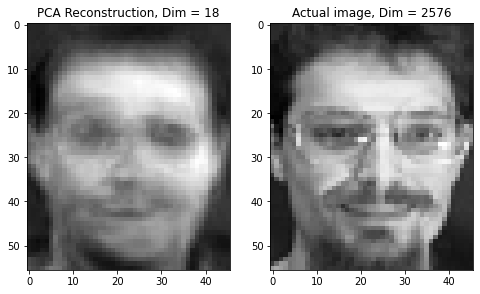

Mean square error (MSE) :  14.560772007209893

K :  19


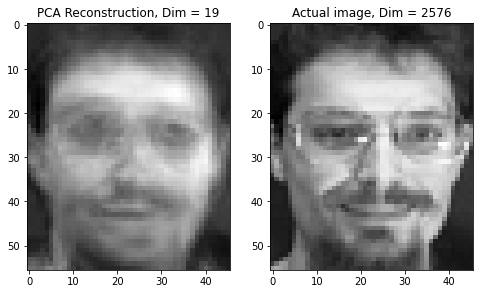

Mean square error (MSE) :  11.919245159629373

K :  20


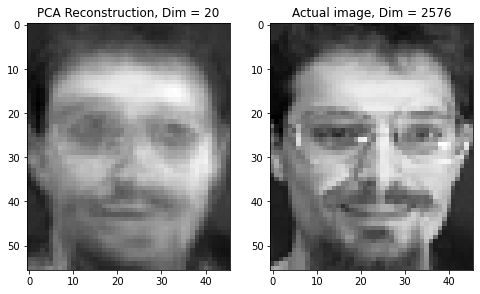

Mean square error (MSE) :  11.863892473054726

K :  21


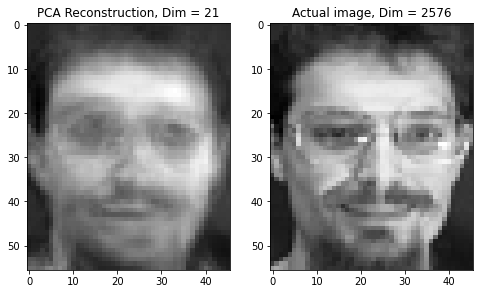

Mean square error (MSE) :  11.861556981128288

K :  22


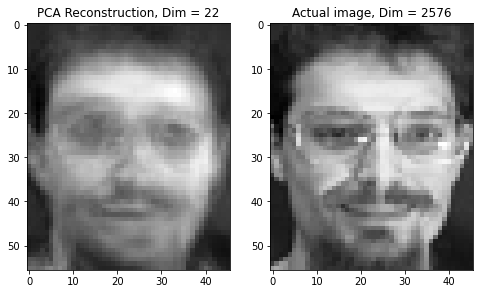

Mean square error (MSE) :  11.850258793404386

K :  23


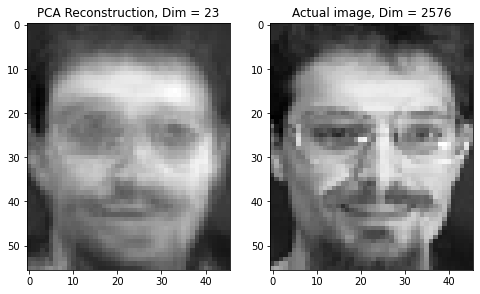

Mean square error (MSE) :  11.59056892879287

K :  24


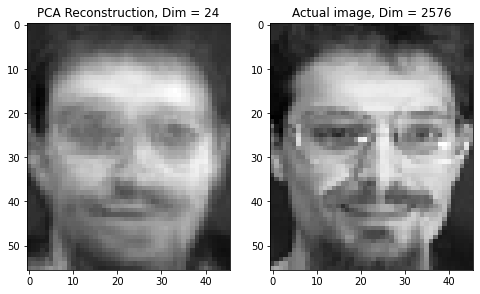

Mean square error (MSE) :  11.176984140728795

K :  25


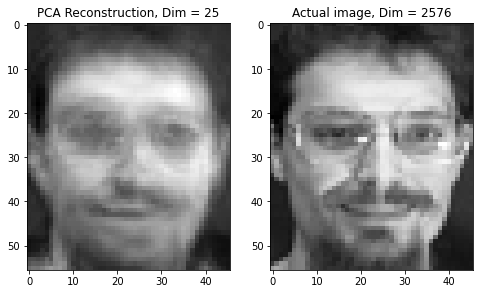

Mean square error (MSE) :  11.026062764908273

K :  26


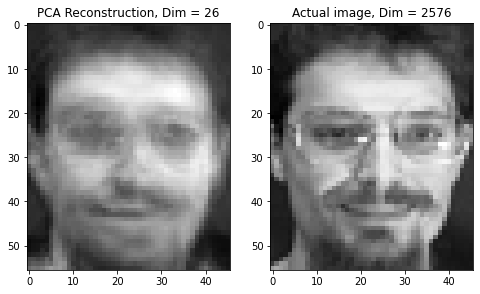

Mean square error (MSE) :  10.968463580744185

K :  27


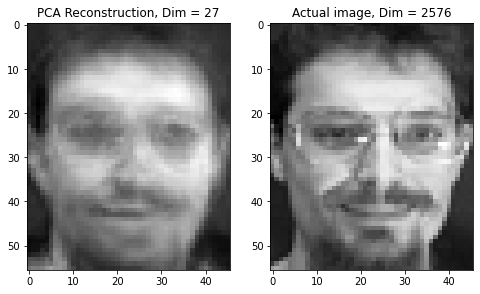

Mean square error (MSE) :  10.784405728581296

K :  28


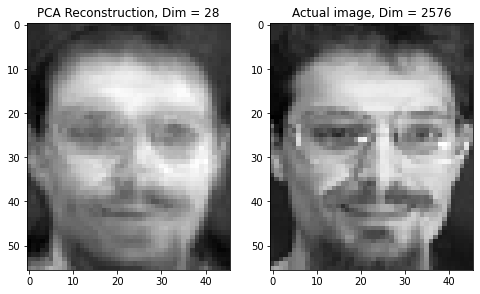

Mean square error (MSE) :  9.373379324671067

K :  29


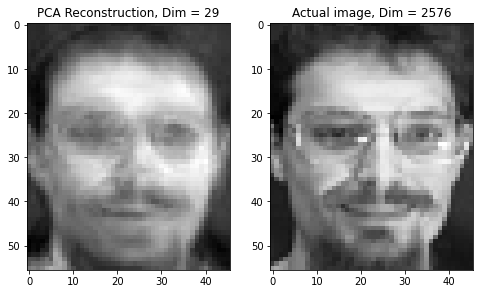

Mean square error (MSE) :  9.328700375193751

K :  30


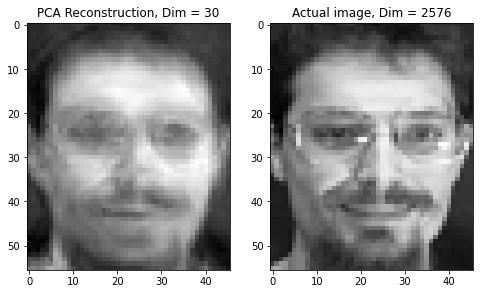

Mean square error (MSE) :  9.322236184302737

K :  31


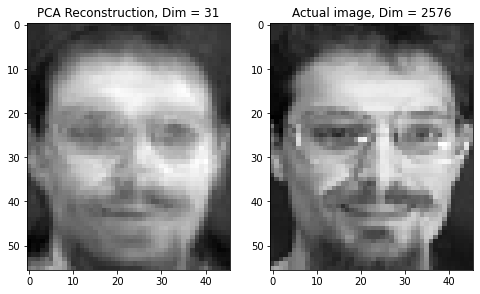

Mean square error (MSE) :  9.322236108875817

K :  32


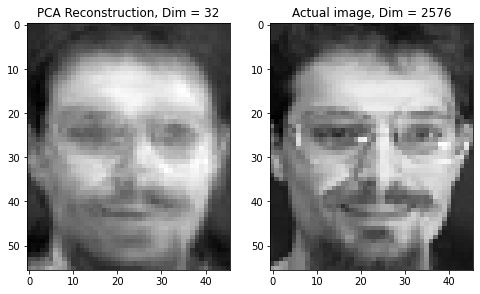

Mean square error (MSE) :  9.187798887325696

K :  33


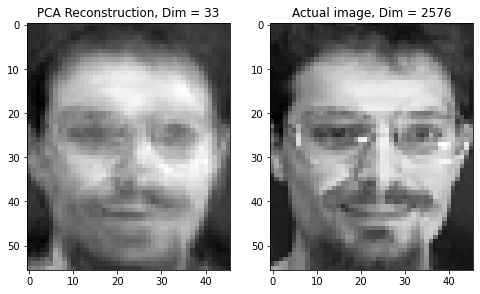

Mean square error (MSE) :  9.080636920527699

K :  34


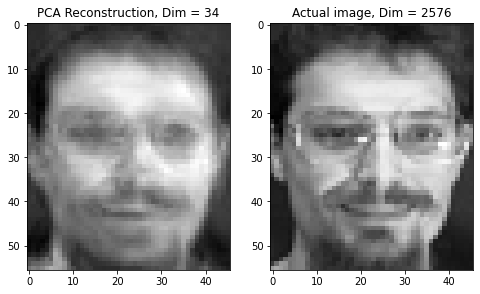

Mean square error (MSE) :  9.080590717539158

K :  35


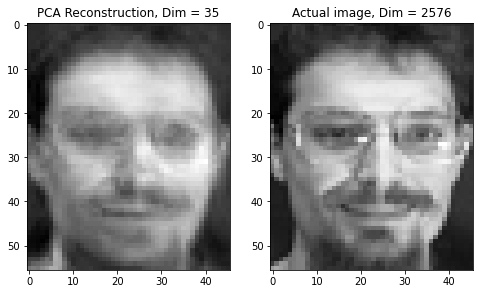

Mean square error (MSE) :  8.092326445066561

K :  36


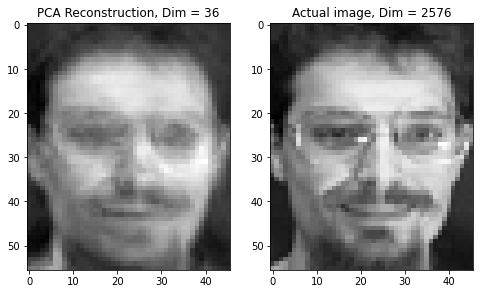

Mean square error (MSE) :  8.014415520020133

K :  37


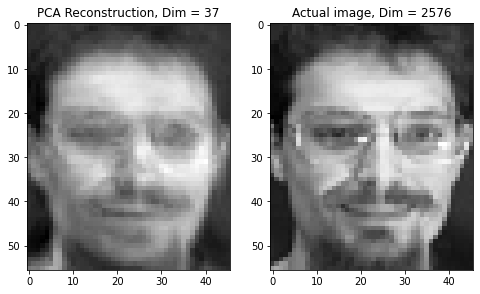

Mean square error (MSE) :  7.879859774227548

K :  38


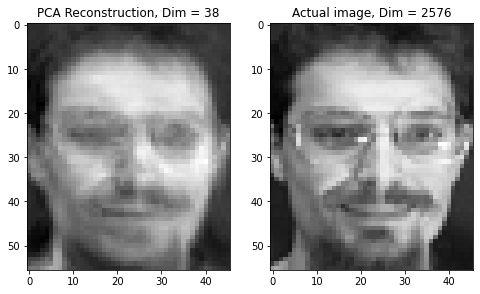

Mean square error (MSE) :  7.727013485092323

K :  39


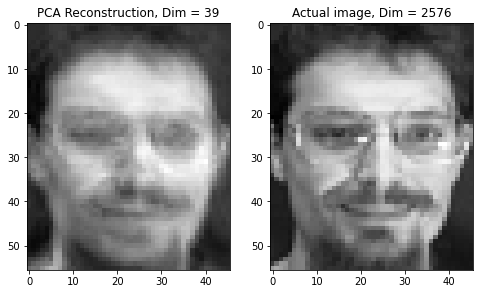

Mean square error (MSE) :  7.467470897684114

K :  40


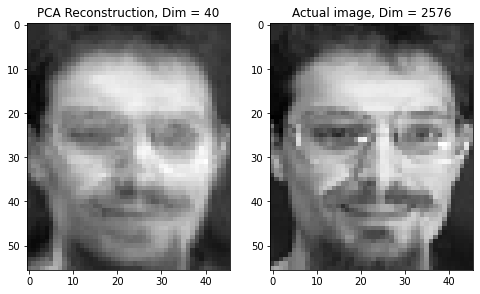

Mean square error (MSE) :  7.467015837394093

K :  41


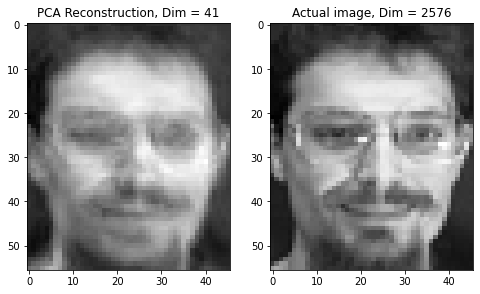

Mean square error (MSE) :  7.351341344145205

K :  42


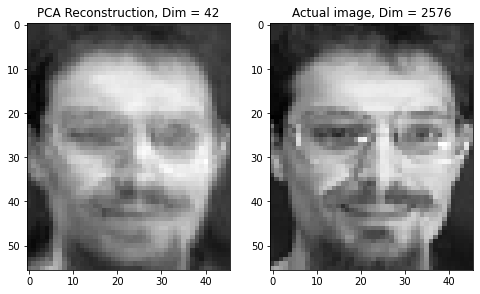

Mean square error (MSE) :  7.234928825921861

K :  43


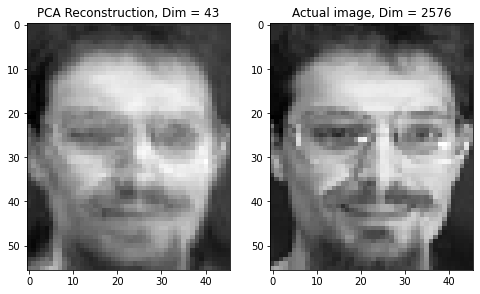

Mean square error (MSE) :  7.121257824769224

K :  44


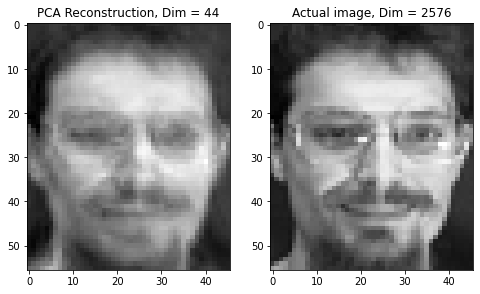

Mean square error (MSE) :  6.876005860745268

K :  45


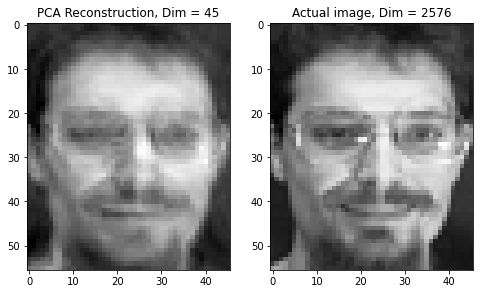

Mean square error (MSE) :  5.865623416902516

K :  46


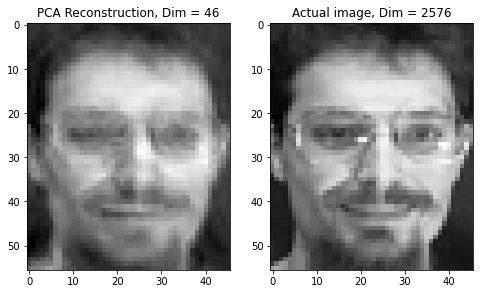

Mean square error (MSE) :  5.833582789885808

K :  47


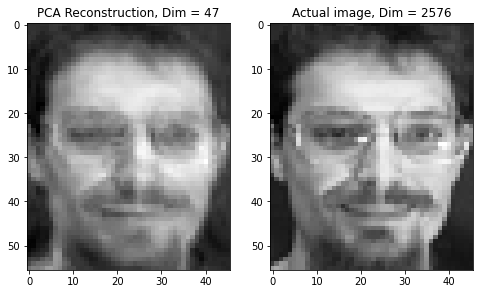

Mean square error (MSE) :  5.703182285390428

K :  48


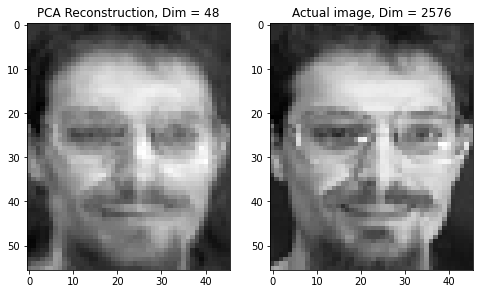

Mean square error (MSE) :  5.495933483075291

K :  49


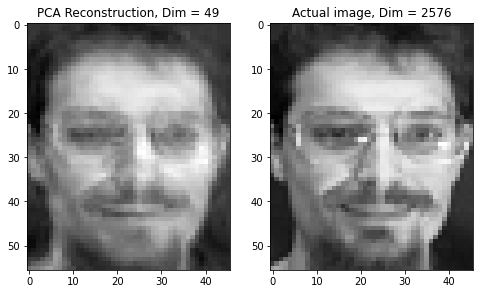

Mean square error (MSE) :  5.262838318874293

K :  50


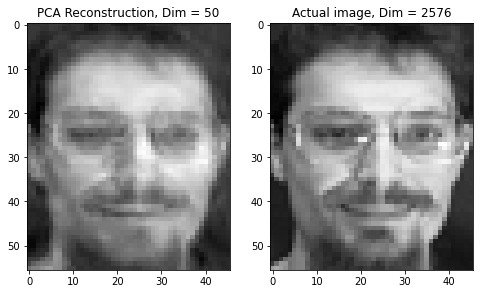

Mean square error (MSE) :  5.084463092322661

K :  51


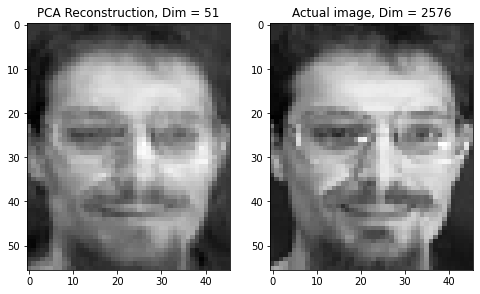

Mean square error (MSE) :  5.013538594851427

K :  52


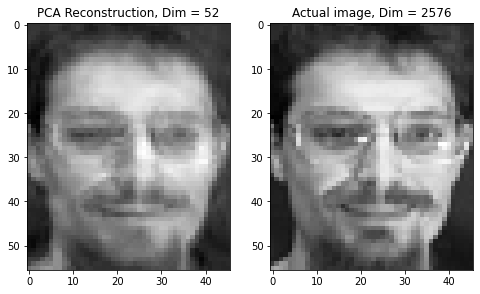

Mean square error (MSE) :  4.9018945573897055

K :  53


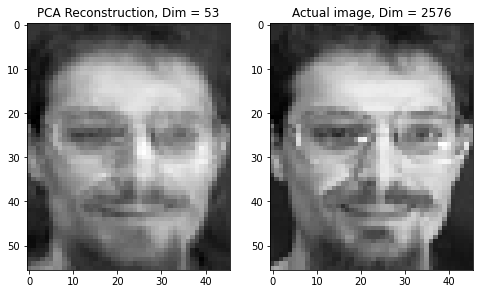

Mean square error (MSE) :  4.735044178663034

K :  54


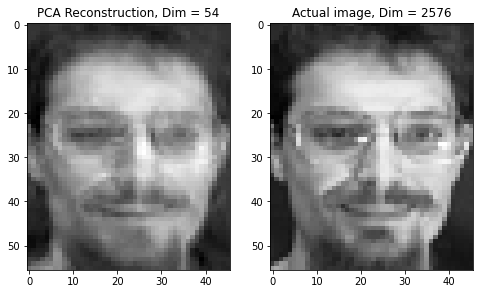

Mean square error (MSE) :  4.684775450812706

K :  55


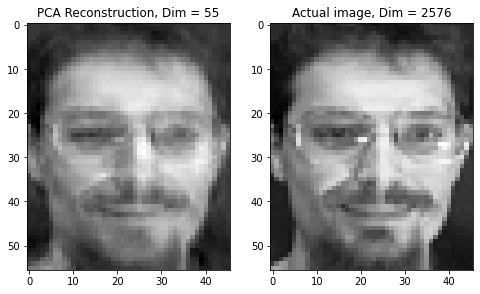

Mean square error (MSE) :  4.345421458131365

K :  56


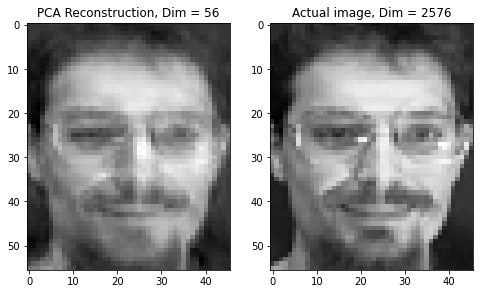

Mean square error (MSE) :  4.280058429700393

K :  57


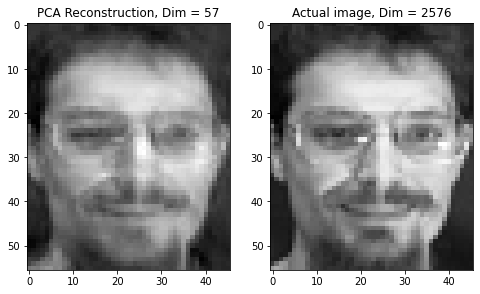

Mean square error (MSE) :  4.11434690119737

K :  58


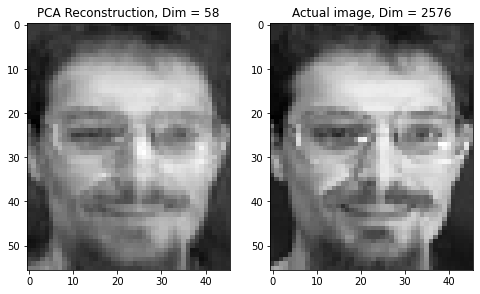

Mean square error (MSE) :  3.864437097240983

K :  59


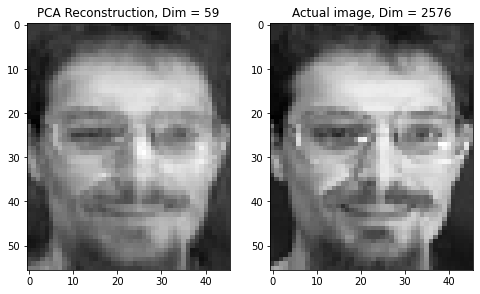

Mean square error (MSE) :  3.8355277108110504

K :  60


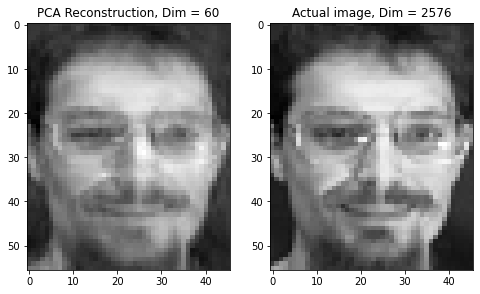

Mean square error (MSE) :  3.751570360618096

K :  61


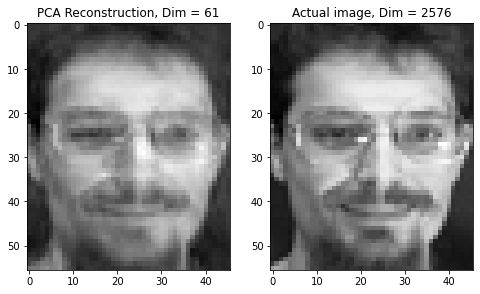

Mean square error (MSE) :  3.7420418850511656

K :  62


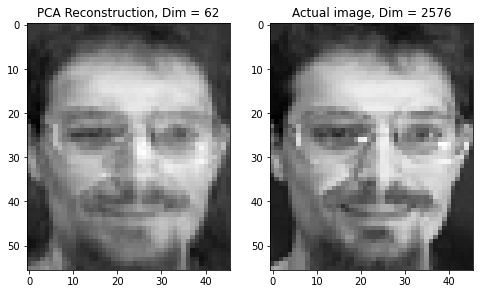

Mean square error (MSE) :  3.63173625916121

K :  63


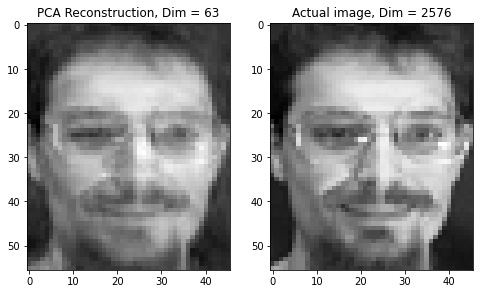

Mean square error (MSE) :  3.6295243946601063

K :  64


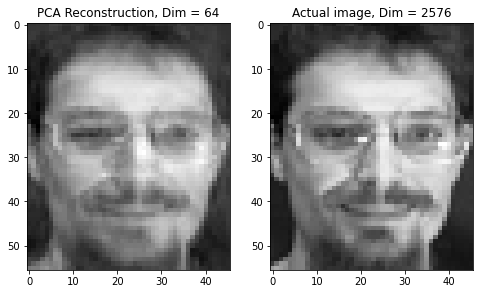

Mean square error (MSE) :  3.61400814561875

K :  65


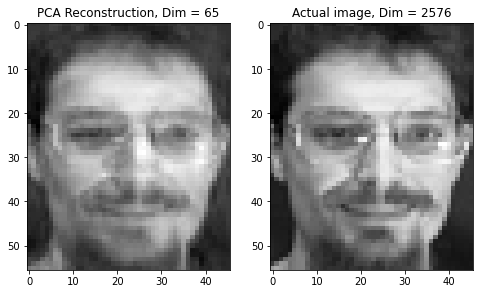

Mean square error (MSE) :  3.5596707422813543

K :  66


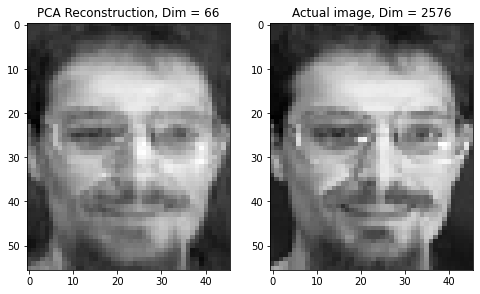

Mean square error (MSE) :  3.5508016942386784

K :  67


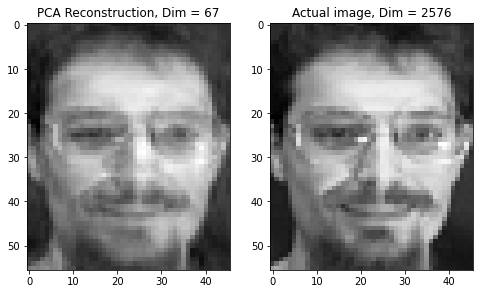

Mean square error (MSE) :  3.5081584779864654

K :  68


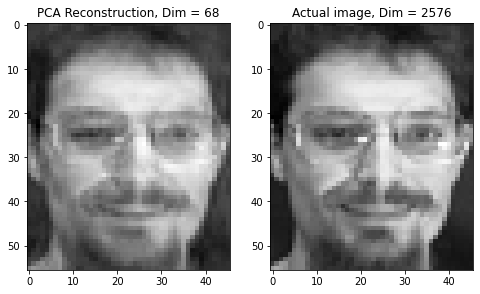

Mean square error (MSE) :  2.8553956049700266

K :  69


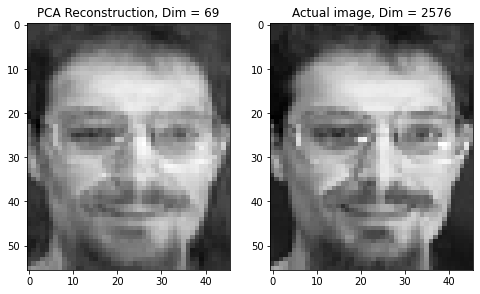

Mean square error (MSE) :  2.8462470073194335

K :  70


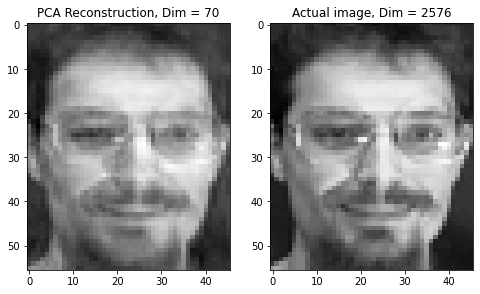

Mean square error (MSE) :  2.8373308348026285

K :  71


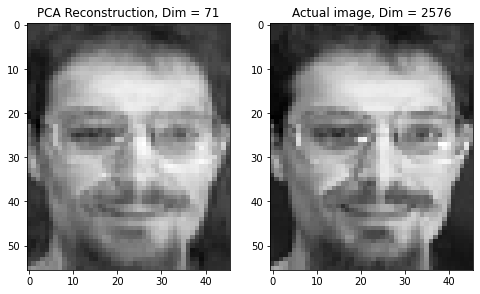

Mean square error (MSE) :  2.775887358255561

K :  72


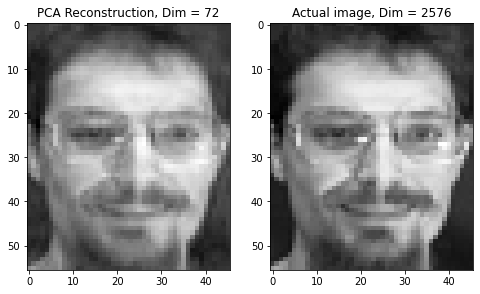

Mean square error (MSE) :  2.4093505203138164

K :  73


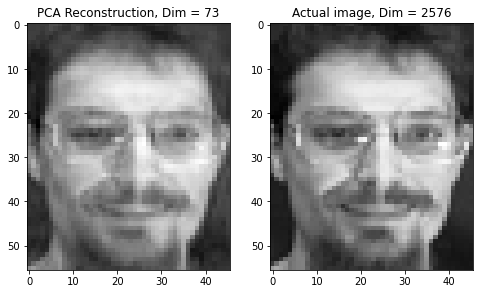

Mean square error (MSE) :  2.4093383824014487

K :  74


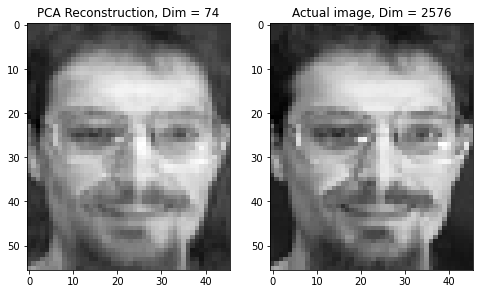

Mean square error (MSE) :  2.3193456335523304

K :  75


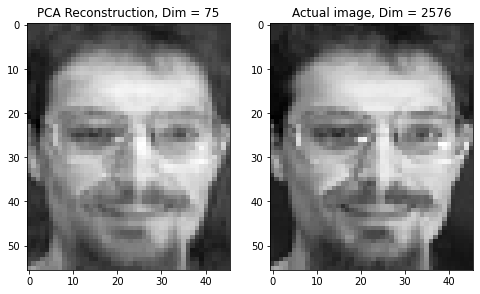

Mean square error (MSE) :  2.31093759068128

K :  76


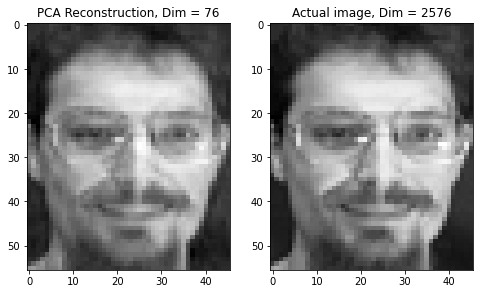

Mean square error (MSE) :  1.4802120448921452

K :  77


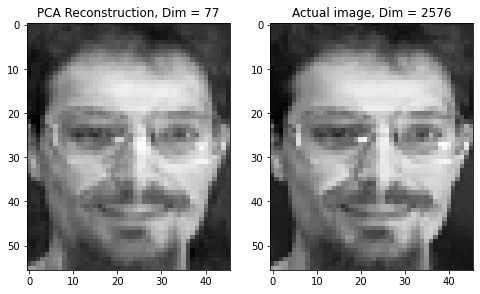

Mean square error (MSE) :  1.4772485166361276

K :  78


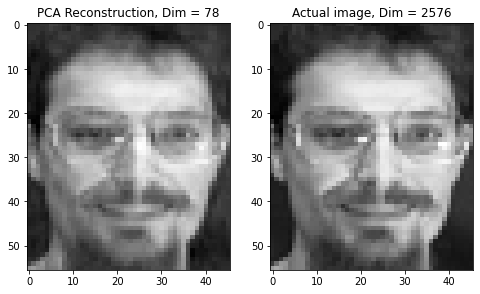

Mean square error (MSE) :  1.4758127659733002

K :  79


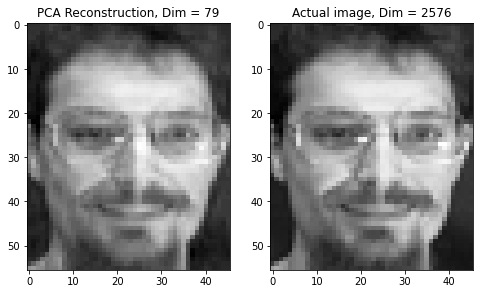

Mean square error (MSE) :  1.4456421203300214

K :  80


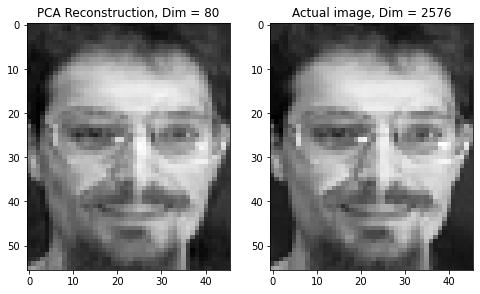

Mean square error (MSE) :  1.1116945937994203

K :  81


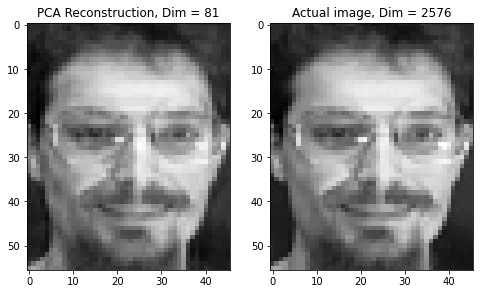

Mean square error (MSE) :  0.847691230528743

K :  82


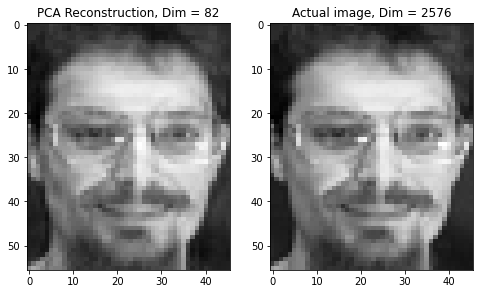

Mean square error (MSE) :  0.7963246092545159

K :  83


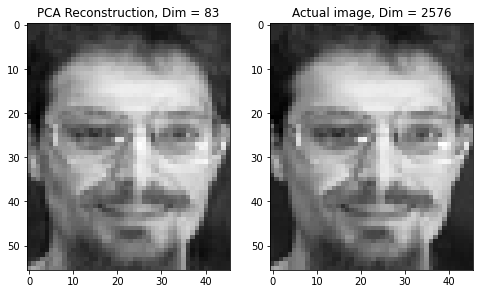

Mean square error (MSE) :  0.7900510452334668

K :  84


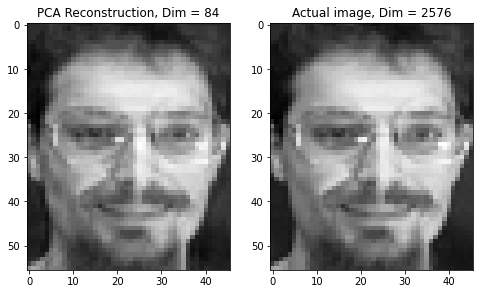

Mean square error (MSE) :  0.777183355586393

K :  85


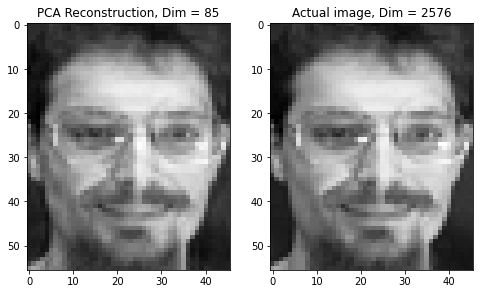

Mean square error (MSE) :  0.7767289944784387

K :  86


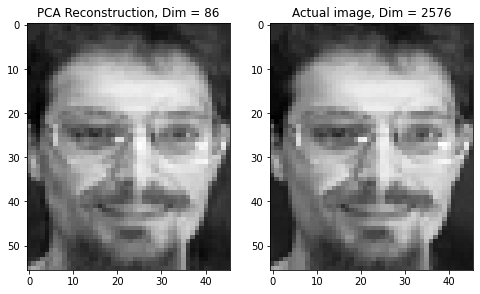

Mean square error (MSE) :  0.7670296242788315

K :  87


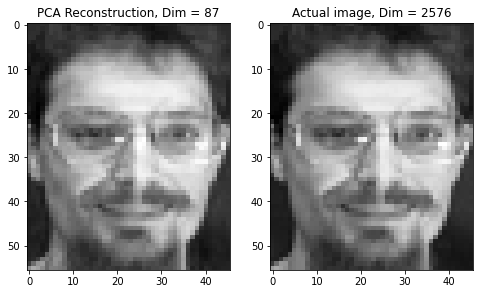

Mean square error (MSE) :  0.5913426087287676

K :  88


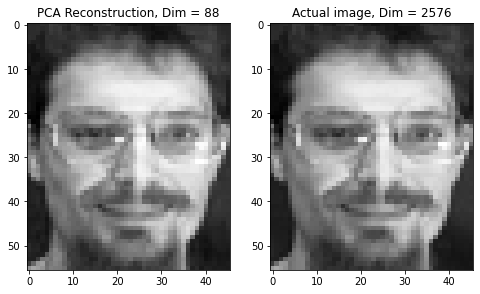

Mean square error (MSE) :  0.4294351663032799

K :  89


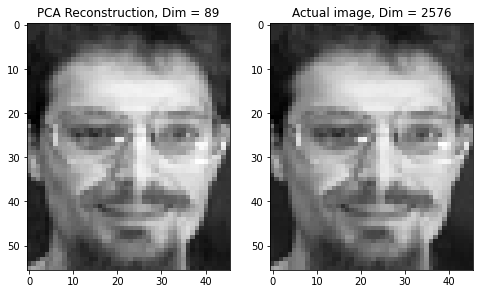

Mean square error (MSE) :  0.42669837971338537

K :  90


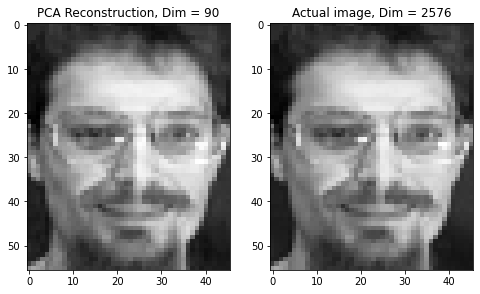

Mean square error (MSE) :  0.4260403584093524

K :  91


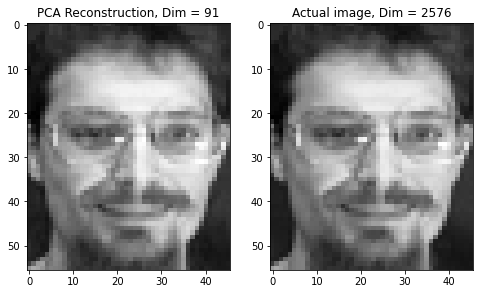

Mean square error (MSE) :  0.31090893388342083

K :  92


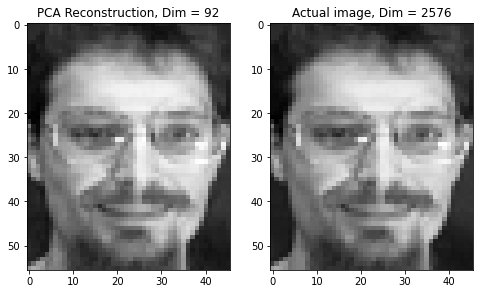

Mean square error (MSE) :  0.3063877009929638

K :  93


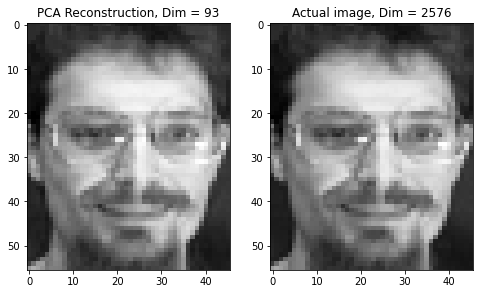

Mean square error (MSE) :  0.24628544953076903

K :  94


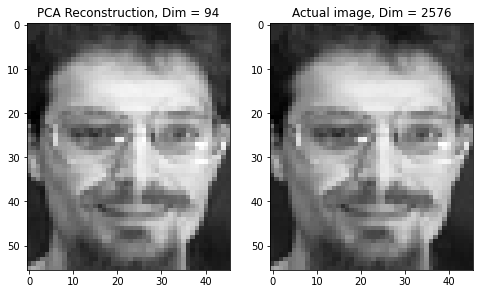

Mean square error (MSE) :  0.22203346531414836

K :  95


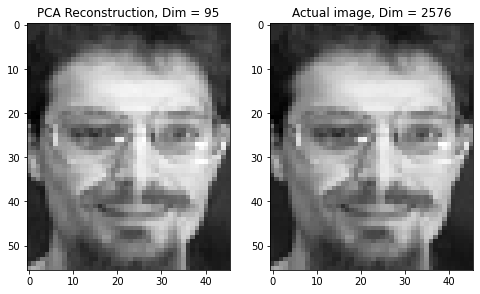

Mean square error (MSE) :  0.20534429380089864

K :  96


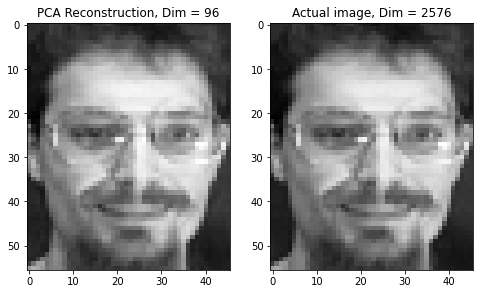

Mean square error (MSE) :  0.20205928824494965

K :  97


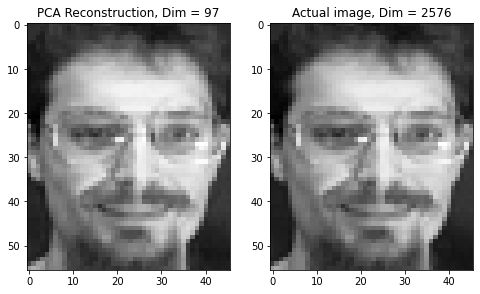

Mean square error (MSE) :  0.15679457393576954

K :  98


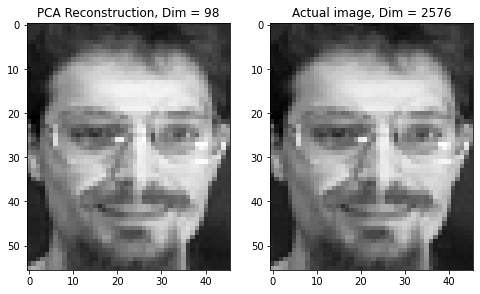

Mean square error (MSE) :  0.15369450867044143

K :  99


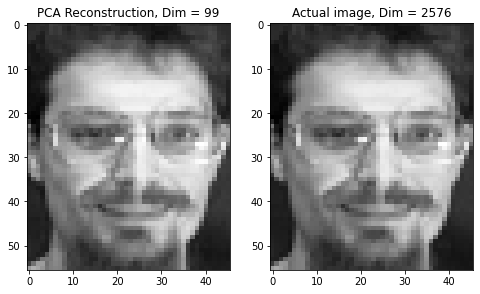

Mean square error (MSE) :  0.14894266906743547

K :  100


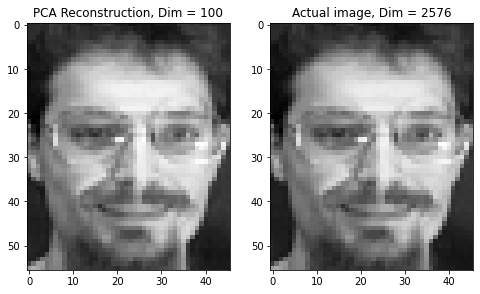

Mean square error (MSE) :  0.12913476979444893

K :  101


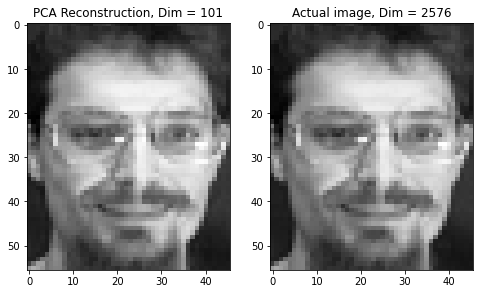

Mean square error (MSE) :  0.12831925779313164

K :  102


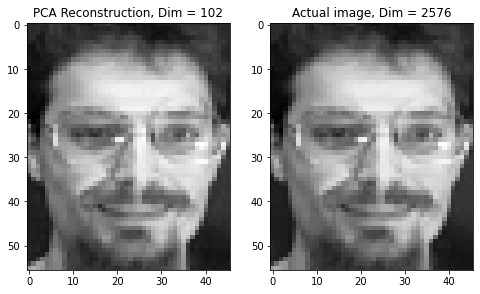

Mean square error (MSE) :  0.1147254743479276

K :  103


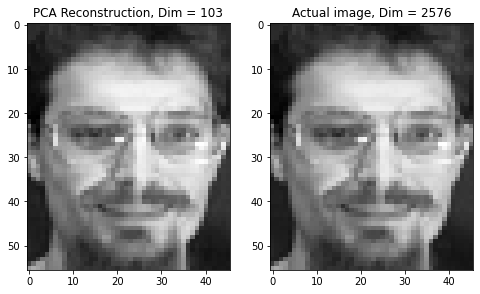

Mean square error (MSE) :  0.10123838063870265

K :  104


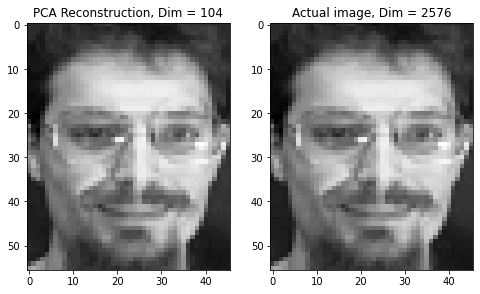

Mean square error (MSE) :  0.04395144951145024

K :  105


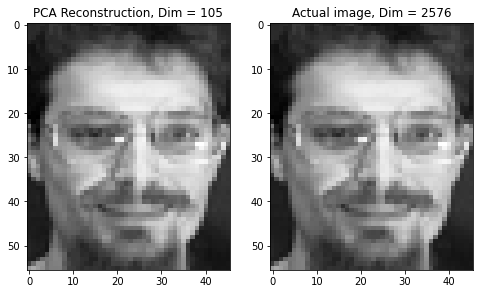

Mean square error (MSE) :  0.03088742497998178

K :  106


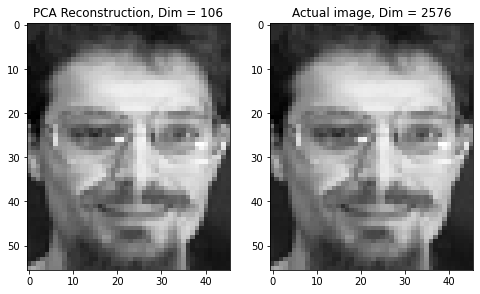

Mean square error (MSE) :  0.030797480858727196

K :  107


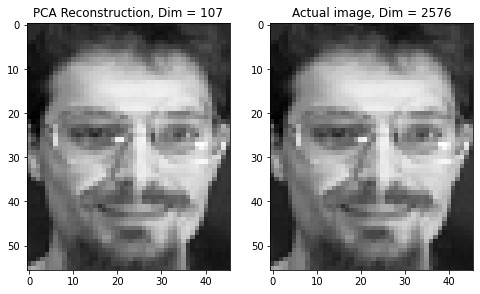

Mean square error (MSE) :  0.02944335647022913

K :  108


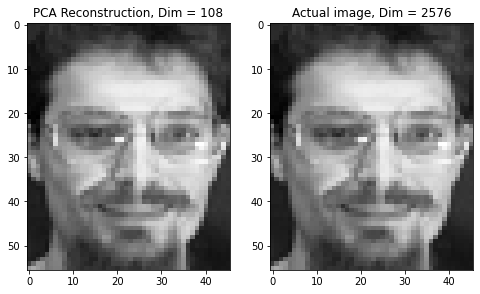

Mean square error (MSE) :  0.027004561073325904

K :  109


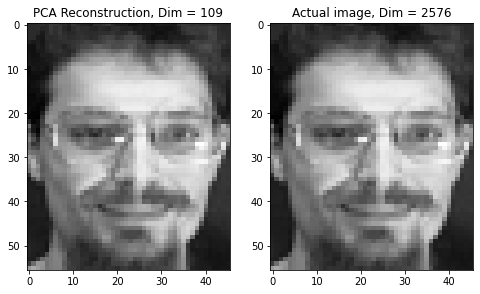

Mean square error (MSE) :  0.02668906323969033

K :  110


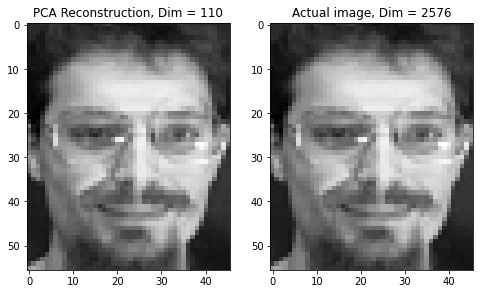

Mean square error (MSE) :  0.013974769545572729

K :  111


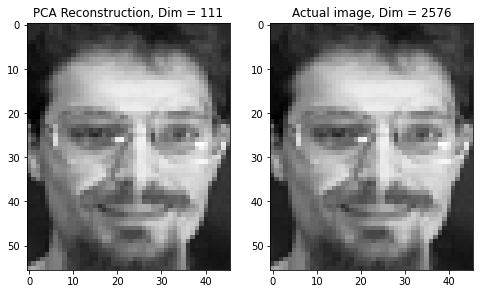

Mean square error (MSE) :  0.01348926738530239

K :  112


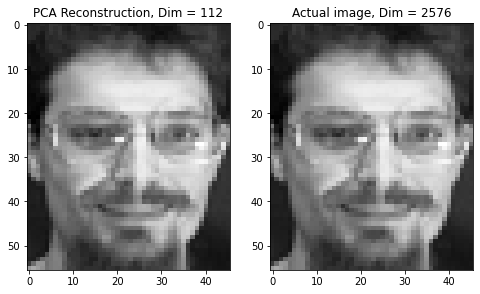

Mean square error (MSE) :  0.011961810626685783

K :  113


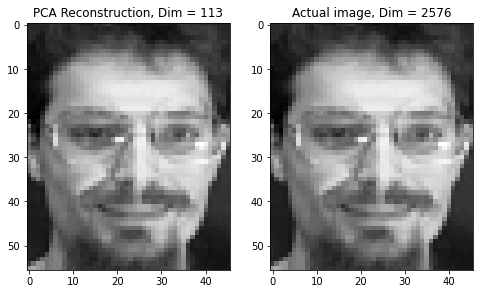

Mean square error (MSE) :  0.011239707789500666

K :  114


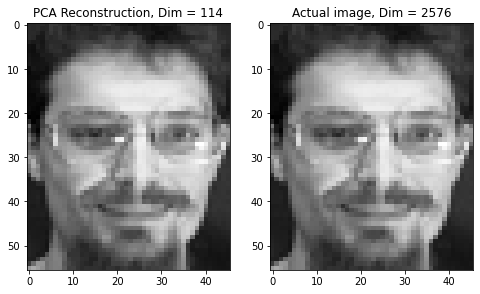

Mean square error (MSE) :  0.0085861570750557

K :  115


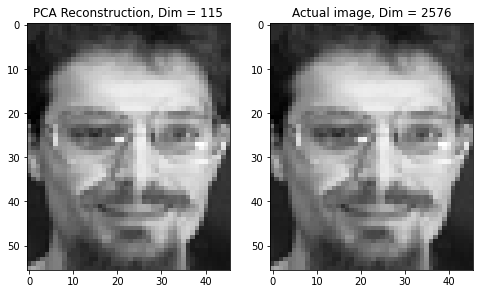

Mean square error (MSE) :  0.007614810382686251

K :  116


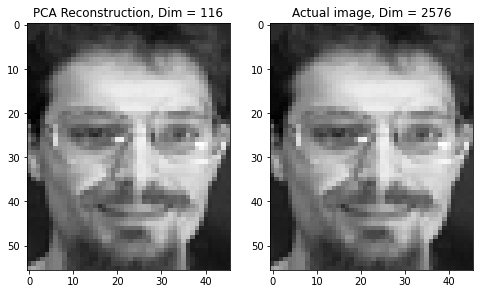

Mean square error (MSE) :  0.004347130586072565

K :  117


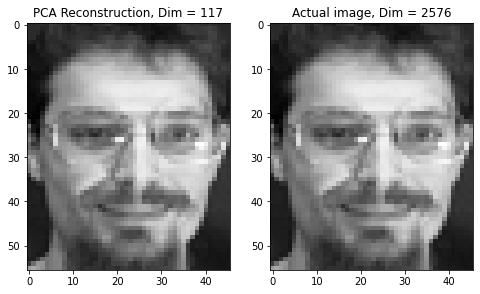

Mean square error (MSE) :  0.0009438169274521792

K :  118


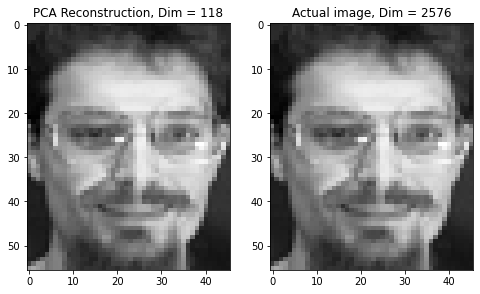

Mean square error (MSE) :  0.00036758919931251883

K :  119


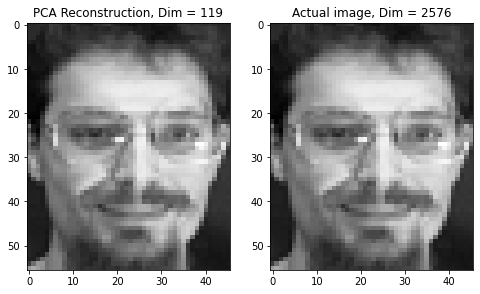

Mean square error (MSE) :  1.0431709025066077e-27


In [32]:
# OT2
mse_list = []
for k in range(119):
    print("\nK : ", k+1)
    PCA_dim = k+1 # From 56*46
    X_pca = np.dot(Q[:, :PCA_dim].T, X_tilda) # New data shape (100, 120)
    pack = Reconstruction(pca_data=X_pca, img_index=48, Q=Q, mean=X_mean, PCA_dim=PCA_dim)
    mse_list.append(pack[2])

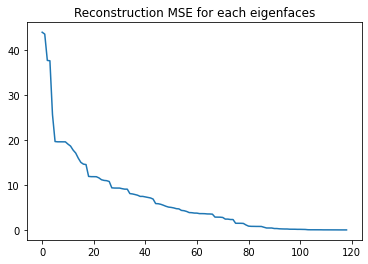

In [33]:
plt.plot(mse_list)
plt.title("Reconstruction MSE for each eigenfaces")
plt.show()

# Linear Discriminant Analysis (LDA)

In [34]:
# In order to assure that Sw is invertible --> Sw must be full rank matrix 
print("Train data : ", X_train.shape)
print("Test data : ",X_test.shape)
print("Train data has ", X_train.shape[1], "Samples with 40 classes")
print("N = ", X_train.shape[1])
print("C = 40")

Train data :  (2576, 120)
Test data :  (2576, 280)
Train data has  120 Samples with 40 classes
N =  120
C = 40


In [35]:
# T21
# Sw rank would be --> (N-C) --> (80) to get full rank.
# But rank will be capped by min(C-1, N-C) --> min(39, 80)
cap_dim = 80
X_train_pca, X_test_pca = get_pca_data(dim=cap_dim, train_data=X_train, test_data=X_test, mean=X_mean)
print(X_train_pca.shape)
print(X_test_pca.shape)

(80, 120)
(80, 280)


In [36]:
def Compute_scatter(data, dim, sample=3):
    sample_size = sample
    Sb = 0
    X_mean_global = np.mean(data, axis=1, keepdims=True)
    X_mean_class = np.mean(data.T.reshape(40,sample_size,dim), axis=1)
    for c in range(40):
        dist_mean = X_mean_class[c,:].reshape(dim,1)-X_mean_global
        Sb += sample*dist_mean.dot(dist_mean.T)
    
    temp_mean_class = X_mean_class
    for i in range(sample_size-1):
        temp_mean_class=np.append(temp_mean_class, X_mean_class, axis=1)
    scatter_mean = (data.T.reshape(40, dim*sample_size)-temp_mean_class).reshape(40*sample_size, dim)
    Sw = np.zeros((dim,dim))
    for c in range(40):
        start = c*sample_size
        end = start+sample_size
        sample = scatter_mean[start:end]
        s = np.zeros((dim,dim))
        for X in sample:
            s += X.reshape(dim, 1).dot(X.reshape(dim, 1).T)
            Sw += s

    return Sb, Sw

def get_LDA_eigenface(Sb, Sw):
    Sw_inv = np.linalg.inv(Sw)
    LDA_mat = np.dot(Sw_inv, Sb)
    D_lda, Q_lda = np.linalg.eig(LDA_mat)
    Q_lda = Q_lda/np.linalg.norm(Q_lda, axis=0)
    return D_lda, Q_lda

def calculate_fisherfaces(eigenPCA, eigenLDA):
    return np.dot(eigenPCA, eigenLDA)

In [37]:
# Compute Sb, Sw
Sb, Sw = Compute_scatter(data=X_train_pca, dim=cap_dim)

In [38]:
D_lda, Q_lda = get_LDA_eigenface(Sb, Sw)
D_lda = D_lda.real
Q_lda = Q_lda.real

In [69]:
Q_fisherfaces = calculate_fisherfaces(eigenPCA=Q[:,:cap_dim], eigenLDA=Q_lda)
Q_fisherfaces.shape

(2576, 80)

PCA Projection


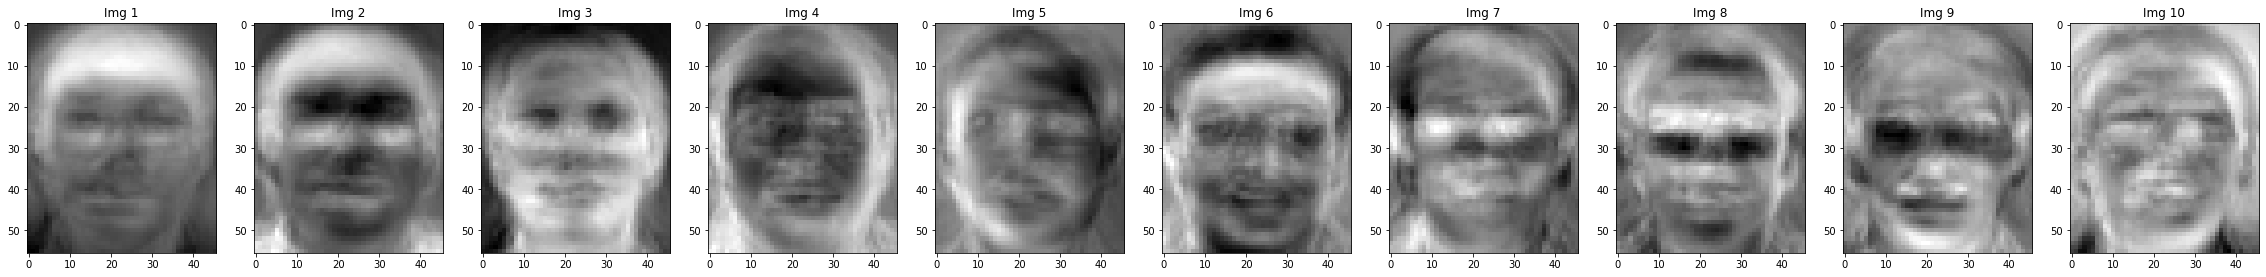

LDA Projection


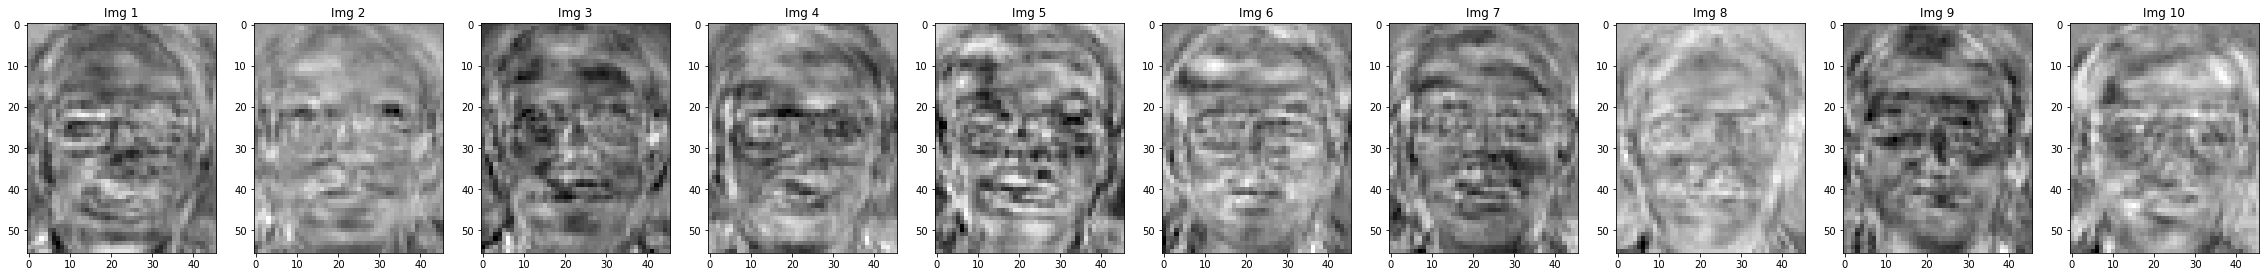

In [51]:
# T23
print("PCA Projection")
plt.figure(figsize=(40,20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title('Img {}'.format(i+1))
    plt.imshow(Q[:, i].reshape(56,46), cmap="gray")
plt.show()

print("LDA Projection")
plt.figure(figsize=(40,20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title('Img {}'.format(i+1))
    plt.imshow(Q_fisherfaces[:, i].reshape(56,46), cmap="gray")
plt.show()

## LDA Face verification.

In [41]:
# Get PCA data
cap_dim = 80
X_train_pca, X_test_pca = get_pca_data(dim=cap_dim, train_data=X_train, test_data=X_test, mean=X_mean)

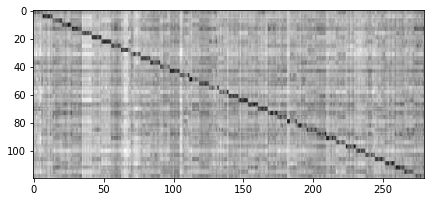

In [42]:
# Compute Sb, Sw
Sb, Sw = Compute_scatter(data=X_train_pca, dim=cap_dim, sample=3)

# get lda eigenface 
D_lda, Q_lda = get_LDA_eigenface(Sb, Sw)
Q_lda = Q_lda.real

X_train_lda = np.dot(Q_lda[:,:39].T, X_train_pca)
X_test_lda = np.dot(Q_lda[:,:39].T, X_test_pca)

sim_lda = get_Similarity_pca(X_train_lda, X_test_lda)
plt.figure(figsize=(7,7))
plt.imshow(sim_lda, cmap="gray")
plt.show()

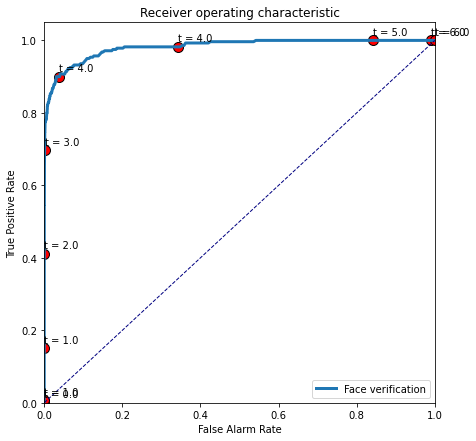

Equal error rate :  0.07211538461538461
At Threshold :  3.661
0.1% FAR Precision :  0.9026665493267623
0.1% FAR Recall :  0.9392857142857143


In [43]:
# T24
_ = plot_roc(sim_lda, size=1000)

In [44]:
# T25
def plot_roc_all(sim_list, size, plot=True):
    plt.figure(figsize=(7,7))
    name_list = ["Plain : 2576 dimensions", "PCA", "LDA"]
    for n, sim in enumerate(sim_list):
        tmin = np.floor(np.min(sim))
        tmax = np.ceil(np.max(sim))
        step = (tmax-tmin)/size
        tpr_list = []
        fpr_list = []
        t_list = np.arange(tmin, tmax, step)
        recall_index = []
        for idx, t in enumerate(t_list):
            conf, tpr, fpr = Face_verification(sim, t)
            tpr_list.append(tpr)
            fpr_list.append(fpr)

        plt.plot(fpr_list, tpr_list, lw=3, label=name_list[n])
        plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Alarm Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic")
        plt.legend(loc="lower right")
    plt.show()

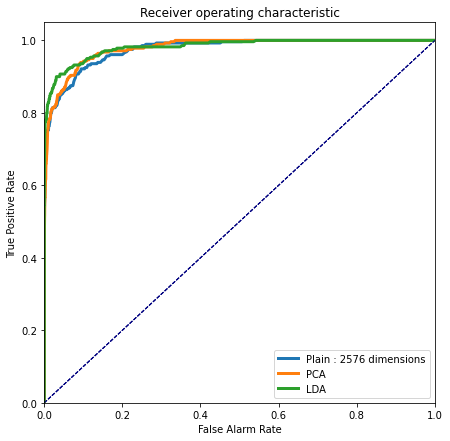

In [45]:
plot_roc_all([sim, sim_pca, sim_lda], size=1000)

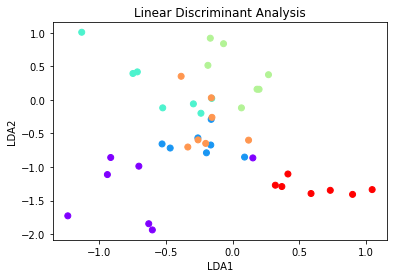

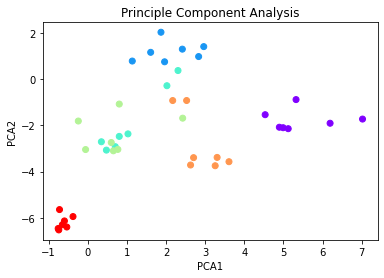

In [53]:
# OT4
person = 6

y = np.array([p for p in range(person) for i in range(7)])
plt.title("Linear Discriminant Analysis")
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.scatter(X_test_lda[0, :person*7], X_test_lda[1, :person*7], c=y, cmap="rainbow")
plt.show()

plt.title("Principle Component Analysis")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.scatter(X_test_pca[0, :person*7], X_test_pca[1, :person*7], c=y, cmap="rainbow")
plt.show()